In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import yfinance as yf

data=yf.download("NVDA",start="2020-01-01",end="2024-05-31")

[*********************100%***********************]  1 of 1 completed


#### 데이터 형식
- Open : 시가
- High : 고가
- Low : 저가
- Close : 종가
- Adj Close : 수정 주가
- Volume : 거래량

<br>수정 주가 : 회사의 가치에 변화를 주지 않는 주식 가격 변동의 영향을 제거하여 주식의 실제 가치 변화를 반영하는 주가

In [3]:
# 파일을 잘 가져왔는지 data의 맨 처음 5개 데이터 출력
print(data.head())

               Open     High      Low    Close  Adj Close     Volume
Date                                                                
2020-01-02  5.96875  5.99775  5.91800  5.99775   5.973633  237536000
2020-01-03  5.87750  5.94575  5.85250  5.90175   5.878020  205384000
2020-01-06  5.80800  5.93175  5.78175  5.92650   5.902669  262636000
2020-01-07  5.95500  6.04425  5.90975  5.99825   5.974131  314856000
2020-01-08  5.99400  6.05100  5.95375  6.00950   5.985335  277108000


/var/folders/g8/348vqs711xbc8d_p9c9jgpvm0000gn/T/ipykernel_10671/906901761.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['Low'][i] < data['Low'][i-1] and data['Low'][i] < data['Low'][i+1]:
/var/folders/g8/348vqs711xbc8d_p9c9jgpvm0000gn/T/ipykernel_10671/906901761.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  supports.append(data['Low'][i])
/var/folders/g8/348vqs711xbc8d_p9c9jgpvm0000gn/T/ipykernel_10671/906901761.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior

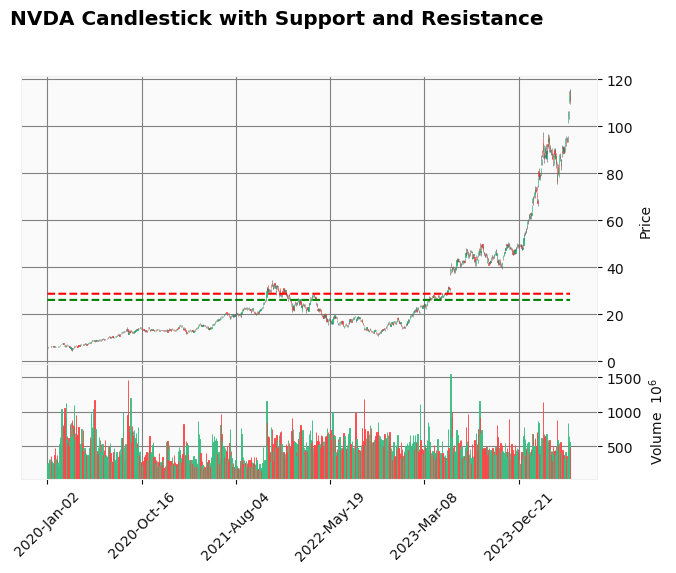

In [4]:
import mplfinance as mpf
import numpy as np

# 2. 지지선과 저항선을 계산하는 함수
def calculate_support_resistance(data):
    # 지지선과 저항선 초기화
    supports = []
    resistances = []

    # 고점과 저점을 찾기 위한 슬라이딩 윈도우
    for i in range(2, len(data) - 2):
        if data['Low'][i] < data['Low'][i-1] and data['Low'][i] < data['Low'][i+1]:
            supports.append(data['Low'][i])
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            resistances.append(data['High'][i])

    # 지지선과 저항선의 평균 계산 (여러 개 있을 수 있으므로)
    support = np.mean(supports) if supports else None
    resistance = np.mean(resistances) if resistances else None

    return support, resistance

# 3. 지지선과 저항선 계산
support, resistance = calculate_support_resistance(data)

# 4. 캔들스틱 차트 그리기 및 지지선과 저항선 추가
# 차트 스타일 설정
mpf_style = mpf.make_mpf_style(base_mpf_style='yahoo', gridstyle='-', gridcolor='gray')

# 지지선과 저항선을 추가한 캔들스틱 차트 그리기
apdict = []
if support:
    apdict.append(mpf.make_addplot([support]*len(data), color='green', linestyle='--', width=1.5))
if resistance:
    apdict.append(mpf.make_addplot([resistance]*len(data), color='red', linestyle='--', width=1.5))

mpf.plot(data, type='candle', style=mpf_style, addplot=apdict, title="NVDA Candlestick with Support and Resistance",
         ylabel="Price", volume=True)


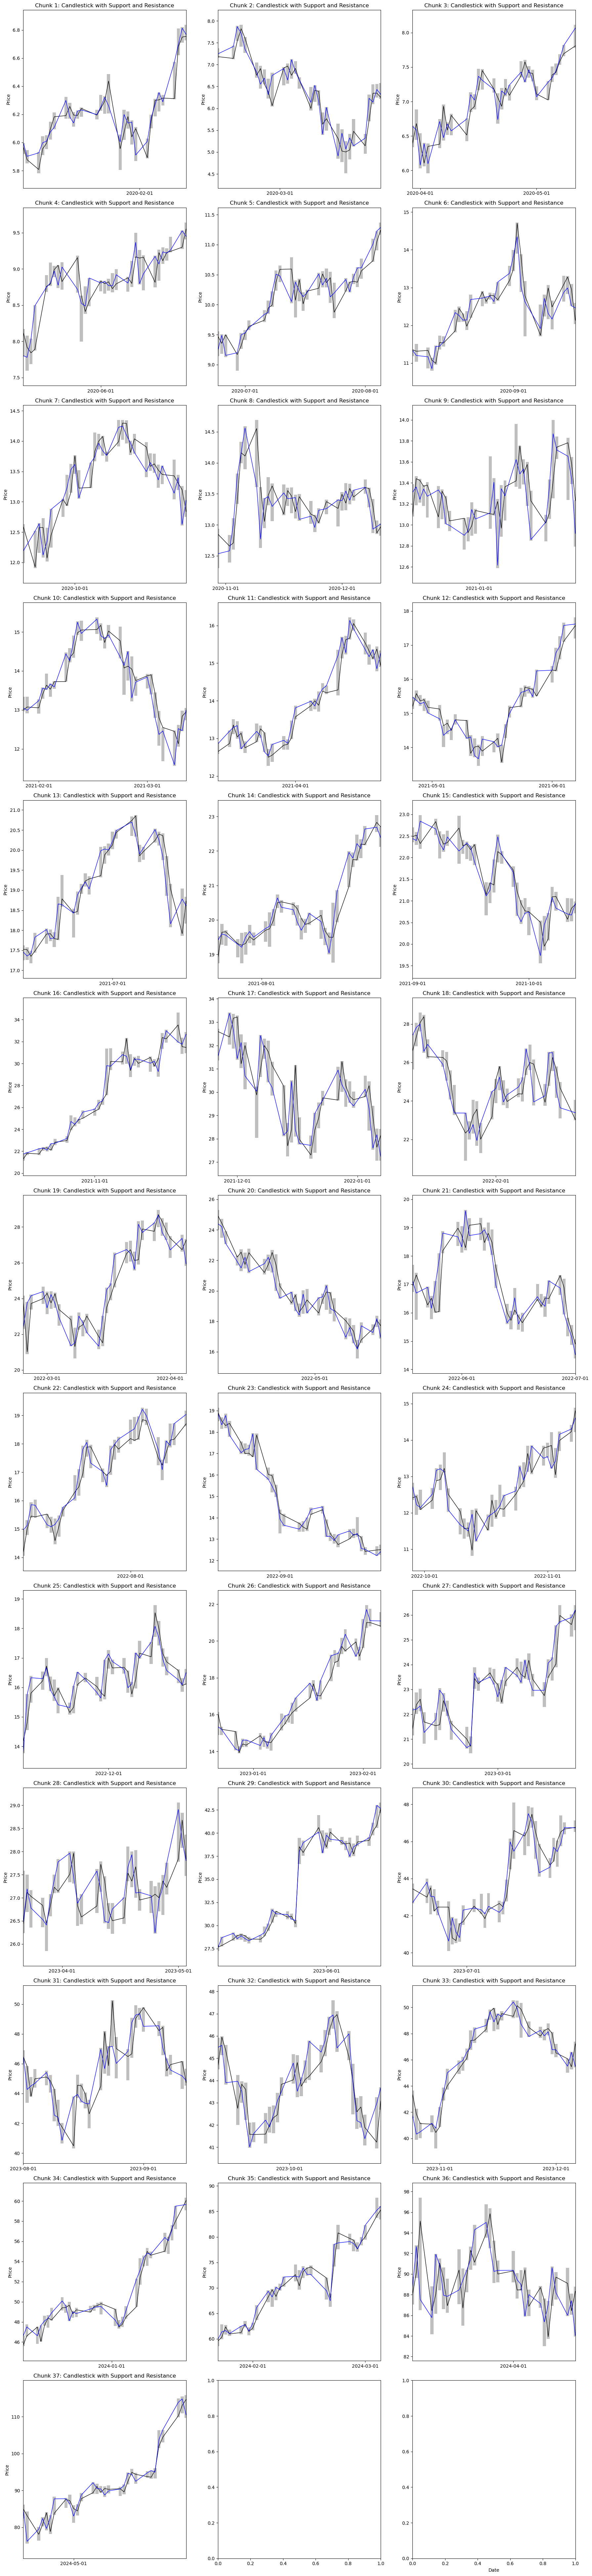

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num

# 2. 지지선과 저항선을 계산하는 함수
def calculate_support_resistance(data, window):
    supports = []
    resistances = []

    for i in range(window, len(data) - window):
        low_slice = data['Low'][i-window:i+window+1]
        high_slice = data['High'][i-window:i+window+1]

        if data['Low'][i] == low_slice.min():
            supports.append(data['Low'][i])
        if data['High'][i] == high_slice.max():
            resistances.append(data['High'][i])

    support = np.mean(supports) if supports else None
    resistance = np.mean(resistances) if resistances else None

    return support, resistance

# 5. 데이터를 일정한 기간으로 자르기
fixed_period = 30  # 예시로 30일 간격으로 데이터를 나눔
chunks = [data.iloc[i:i+fixed_period] for i in range(0, len(data), fixed_period) if len(data.iloc[i:i+fixed_period]) > 1]

# 6. 서브플롯 설정
max_plots_per_row = 3  # 한 행에 최대 3개의 서브플롯
num_chunks = len(chunks)
num_rows = (num_chunks + max_plots_per_row - 1) // max_plots_per_row  # 필요한 행의 수 계산
fig, axes = plt.subplots(num_rows, max_plots_per_row, figsize=(18, num_rows * 6), sharex=False, sharey=False)

# axes가 2D 배열일 수 있지만, 서브플롯이 하나인 경우에는 1D 배열이 될 수 있으므로 처리
if num_rows == 1:
    axes = axes.flatten()
else:
    axes = axes.flatten()

# 7. 각 구간에 대해 지지선과 저항선을 그리기
for idx, (chunk, ax) in enumerate(zip(chunks, axes)):
    if idx >= num_chunks:
        ax.remove()
        continue  # 남은 서브플롯 제거

    support, resistance = calculate_support_resistance(chunk, window=len(chunk)//2)

    # 날짜를 matplotlib 날짜 형식으로 변환
    chunk['Date'] = chunk.index
    chunk['Date'] = date2num(chunk['Date'])

    # 캔들스틱 차트를 그리기 위한 데이터 설정
    ax.plot(chunk['Date'], chunk['Open'], color='black', lw=1)  # Open
    ax.plot(chunk['Date'], chunk['Close'], color='blue', lw=1)  # Close
    ax.bar(chunk['Date'], chunk['High'] - chunk['Low'], bottom=chunk['Low'], color='gray', alpha=0.5)  # High-Low bars

    # 지지선과 저항선 추가
    if support:
        ax.axhline(y=support, color='green', linestyle='--', linewidth=1.5, label='Support')
    if resistance:
        ax.axhline(y=resistance, color='red', linestyle='--', linewidth=1.5, label='Resistance')

    # x축 및 y축 범위 설정
    ax.set_xlim(chunk['Date'].min(), chunk['Date'].max())
    ax.set_ylim(chunk['Low'].min() - (chunk['High'].max() - chunk['Low'].min()) * 0.1, chunk['High'].max() + (chunk['High'].max() - chunk['Low'].min()) * 0.1)

    # 축 설정
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())

    # 레이블이 있는 경우에만 legend() 호출
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend()

    ax.set_title(f"Chunk {idx+1}: Candlestick with Support and Resistance")
    ax.set_ylabel("Price")

# X축 레이블을 설정
plt.xlabel("Date")

# 레이아웃 조정
plt.tight_layout()
plt.show()